# Load Data

In [18]:
import numpy as np
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten,Dropout
from keras.layers import Conv2D,BatchNormalization,MaxPooling2D,Reshape,LSTM
from keras.utils import to_categorical
from keras import layers, regularizers
import matplotlib.pyplot as plt
import os


In [10]:
data_folder = './EEG-Data'
os.chdir(data_folder)
print(os.getcwd())

C:\Users\tiffh\ECE-C147\Deep-Learning-EEG-BCI-Signal-Processing\EEG-Data


(2115, 22, 1000)


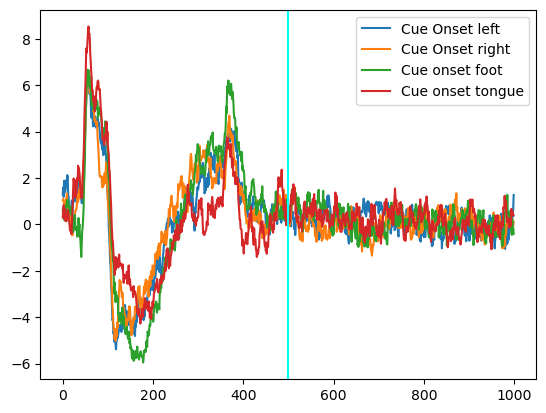

In [25]:
## Loading and visualizing the data

## Loading the dataset


X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
person_train_valid = np.load("person_train_valid.npy")
X_train_valid = np.load("X_train_valid.npy")
print(X_train_valid.shape)
y_train_valid = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")

## Adjusting the labels so that 

# Cue onset left - 0
# Cue onset right - 1
# Cue onset foot - 2
# Cue onset tongue - 3

y_train_valid -= 769
y_test -= 769

## Visualizing the data

ch_data = X_train_valid[:,8,:]


class_0_ind = np.where(y_train_valid == 0)
ch_data_class_0 = ch_data[class_0_ind]
avg_ch_data_class_0 = np.mean(ch_data_class_0,axis=0)


class_1_ind = np.where(y_train_valid == 1)
ch_data_class_1 = ch_data[class_1_ind]
avg_ch_data_class_1 = np.mean(ch_data_class_1,axis=0)

class_2_ind = np.where(y_train_valid == 2)
ch_data_class_2 = ch_data[class_2_ind]
avg_ch_data_class_2 = np.mean(ch_data_class_2,axis=0)

class_3_ind = np.where(y_train_valid == 3)
ch_data_class_3 = ch_data[class_3_ind]
avg_ch_data_class_3 = np.mean(ch_data_class_3,axis=0)


plt.plot(np.arange(1000),avg_ch_data_class_0)
plt.plot(np.arange(1000),avg_ch_data_class_1)
plt.plot(np.arange(1000),avg_ch_data_class_2)
plt.plot(np.arange(1000),avg_ch_data_class_3)
plt.axvline(x=500, label='line at t=500',c='cyan')

plt.legend(["Cue Onset left", "Cue Onset right", "Cue onset foot", "Cue onset tongue"])






In [26]:
def train_data_prep(X,y,sub_sample,average,noise):
    
    total_X = None
    total_y = None
    
    # Trimming the data (sample,22,1000) -> (sample,22,800)
    X = X[:,:,0:800]
    print('Shape of X after trimming:',X.shape)
    
    # Maxpooling the data (sample,22,800) -> (sample,22,800/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, sub_sample), axis=3)
    
    
    total_X = X_max
    total_y = y
    print('Shape of X after maxpooling:',total_X.shape)
    
    # Averaging + noise 
    X_average = np.mean(X.reshape(X.shape[0], X.shape[1], -1, average),axis=3)
    X_average = X_average + np.random.normal(0.0, 0.5, X_average.shape)
    
    total_X = np.vstack((total_X, X_average))
    total_y = np.hstack((total_y, y))
    print('Shape of X after averaging+noise and concatenating:',total_X.shape)
    
    # Subsampling
    
    for i in range(sub_sample):
        
        X_subsample = X[:, :, i::sub_sample] + \
                            (np.random.normal(0.0, 0.5, X[:, :,i::sub_sample].shape) if noise else 0.0)
            
        total_X = np.vstack((total_X, X_subsample))
        total_y = np.hstack((total_y, y))
        
    
    print('Shape of X after subsampling and concatenating:',total_X.shape)
    print('Shape of Y:',total_y.shape)
    return total_X,total_y


def test_data_prep(X):
    
    total_X = None
    
    
    # Trimming the data (sample,22,1000) -> (sample,22,800)
    X = X[:,:,0:800]
    print('Shape of X after trimming:',X.shape)
    
    # Maxpooling the data (sample,22,800) -> (sample,22,800/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, 2), axis=3)
    
    
    total_X = X_max
    print('Shape of X after maxpooling:',total_X.shape)
    
    return total_X




In [27]:

## Preprocessing the dataset

X_train_valid_prep,y_train_valid_prep = train_data_prep(X_train_valid,y_train_valid,2,2,True)
X_test_prep = test_data_prep(X_test) 

## Random splitting and reshaping the data

# First generating the training and validation indices using random splitting
ind_valid = np.random.choice(8460, 1000, replace=False)
ind_train = np.array(list(set(range(8460)).difference(set(ind_valid))))

# Creating the training and validation sets using the generated indices
(x_train, x_valid) = X_train_valid_prep[ind_train], X_train_valid_prep[ind_valid] 
(y_train, y_valid) = y_train_valid_prep[ind_train], y_train_valid_prep[ind_valid]
print('Shape of training set:',x_train.shape)
print('Shape of validation set:',x_valid.shape)
print('Shape of training labels:',y_train.shape)
print('Shape of validation labels:',y_valid.shape)


# Converting the labels to categorical variables for multiclass classification
y_train = to_categorical(y_train, 4)
y_valid = to_categorical(y_valid, 4)
y_test = to_categorical(y_test, 4)
print('Shape of training labels after categorical conversion:',y_train.shape)
print('Shape of validation labels after categorical conversion:',y_valid.shape)
print('Shape of test labels after categorical conversion:',y_test.shape)

# Adding width of the segment to be 1
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], x_train.shape[2], 1)
x_test = X_test_prep.reshape(X_test_prep.shape[0], X_test_prep.shape[1], X_test_prep.shape[2], 1)
print('Shape of training set after adding width info:',x_train.shape)
print('Shape of validation set after adding width info:',x_valid.shape)
print('Shape of test set after adding width info:',x_test.shape)


# Reshaping the training and validation dataset
x_train = np.swapaxes(x_train, 1,3)
x_train = np.swapaxes(x_train, 1,2)
x_valid = np.swapaxes(x_valid, 1,3)
x_valid = np.swapaxes(x_valid, 1,2)
x_test = np.swapaxes(x_test, 1,3)
x_test = np.swapaxes(x_test, 1,2)
print('Shape of training set after dimension reshaping:',x_train.shape)
print('Shape of validation set after dimension reshaping:',x_valid.shape)
print('Shape of test set after dimension reshaping:',x_test.shape)


Shape of X after trimming: (2115, 22, 800)
Shape of X after maxpooling: (2115, 22, 400)
Shape of X after averaging+noise and concatenating: (4230, 22, 400)
Shape of X after subsampling and concatenating: (8460, 22, 400)
Shape of Y: (8460,)
Shape of X after trimming: (443, 22, 800)
Shape of X after maxpooling: (443, 22, 400)
Shape of training set: (7460, 22, 400)
Shape of validation set: (1000, 22, 400)
Shape of training labels: (7460,)
Shape of validation labels: (1000,)
Shape of training labels after categorical conversion: (7460, 4)
Shape of validation labels after categorical conversion: (1000, 4)
Shape of test labels after categorical conversion: (443, 4)
Shape of training set after adding width info: (7460, 22, 400, 1)
Shape of validation set after adding width info: (1000, 22, 400, 1)
Shape of test set after adding width info: (443, 22, 400, 1)
Shape of training set after dimension reshaping: (7460, 400, 1, 22)
Shape of validation set after dimension reshaping: (1000, 400, 1, 22)

# Hybrid Model Architecture

In [29]:
# Building the model using sequential class
hybrid_cnn_lstm_model = Sequential()

for filter, num_filter in zip([10 for _ in range(4)], [25, 50, 100, 200]):
    hybrid_cnn_lstm_model.add(Conv2D(filters=num_filter, kernel_size=(filter,1), padding='same', activation='elu', input_shape=(400,1,22)))
    hybrid_cnn_lstm_model.add(MaxPooling2D(pool_size=(3,1), padding='same')) # Read the keras documentation
    hybrid_cnn_lstm_model.add(BatchNormalization())
    hybrid_cnn_lstm_model.add(Dropout(0.6))


# FC+LSTM layers
hybrid_cnn_lstm_model.add(Flatten()) # Adding a flattening operation to the output of CNN block
hybrid_cnn_lstm_model.add(Dense((40))) # FC layer with 100 units
hybrid_cnn_lstm_model.add(Reshape((40,1))) # Reshape my output of FC layer so that it's compatible
hybrid_cnn_lstm_model.add(LSTM(10, dropout=0.4, recurrent_dropout=0.1, input_shape=(40,1), return_sequences=False))


# Output layer with Softmax activation 
hybrid_cnn_lstm_model.add(Dense(4, activation='softmax')) # Output FC layer with softmax activation


# Printing the model summary
hybrid_cnn_lstm_model.summary()




Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 400, 1, 25)        5525      
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 134, 1, 25)        0         
 ng2D)                                                           
                                                                 
 batch_normalization_16 (Ba  (None, 134, 1, 25)        100       
 tchNormalization)                                               
                                                                 
 dropout_16 (Dropout)        (None, 134, 1, 25)        0         
                                                                 
 conv2d_17 (Conv2D)          (None, 134, 1, 50)        12550     
                                                                 
 max_pooling2d_17 (MaxPooli  (None, 45, 1, 50)        

# Train Hybrid Model

In [30]:
# Model parameters
learning_rate = 1e-3
epochs = 100
hybrid_optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

In [32]:
from keras.callbacks import ReduceLROnPlateau

# Compiling the model
hybrid_cnn_lstm_model.compile(loss='categorical_crossentropy',
                 optimizer=hybrid_optimizer,
                 metrics=['accuracy'])

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.8,
                             patience=10, min_lr=5e-5)
# Training and validating the model
hybrid_cnn_lstm_model_results = hybrid_cnn_lstm_model.fit(x_train,
             y_train,
             batch_size=64,
             epochs=epochs,
             validation_data=(x_valid, y_valid), 
             callbacks=[reduce_lr],
             verbose=True)



Epoch 1/100
117/117 [==============================] - 36s 158ms/step - loss: 1.3808 - accuracy: 0.2737 - val_loss: 1.3555 - val_accuracy: 0.3210 - lr: 0.0010
Epoch 2/100
117/117 [==============================] - 16s 137ms/step - loss: 1.3362 - accuracy: 0.3479 - val_loss: 1.2817 - val_accuracy: 0.3840 - lr: 0.0010
Epoch 3/100
117/117 [==============================] - 16s 136ms/step - loss: 1.2807 - accuracy: 0.3916 - val_loss: 1.2174 - val_accuracy: 0.4570 - lr: 0.0010
Epoch 4/100
117/117 [==============================] - 16s 134ms/step - loss: 1.2306 - accuracy: 0.4374 - val_loss: 1.1831 - val_accuracy: 0.4740 - lr: 0.0010
Epoch 5/100
117/117 [==============================] - 16s 133ms/step - loss: 1.1967 - accuracy: 0.4582 - val_loss: 1.1516 - val_accuracy: 0.5020 - lr: 0.0010
Epoch 6/100
117/117 [==============================] - 15s 130ms/step - loss: 1.1723 - accuracy: 0.4723 - val_loss: 1.1170 - val_accuracy: 0.5240 - lr: 0.0010
Epoch 7/100
117/117 [=========================

117/117 [==============================] - 15s 130ms/step - loss: 0.5814 - accuracy: 0.7800 - val_loss: 0.3473 - val_accuracy: 0.8920 - lr: 0.0010
Epoch 53/100
117/117 [==============================] - 15s 128ms/step - loss: 0.5889 - accuracy: 0.7757 - val_loss: 0.3425 - val_accuracy: 0.9110 - lr: 0.0010
Epoch 54/100
117/117 [==============================] - 15s 130ms/step - loss: 0.5762 - accuracy: 0.7842 - val_loss: 0.3460 - val_accuracy: 0.8850 - lr: 0.0010
Epoch 55/100
117/117 [==============================] - 15s 127ms/step - loss: 0.5721 - accuracy: 0.7779 - val_loss: 0.3229 - val_accuracy: 0.9000 - lr: 0.0010
Epoch 56/100
117/117 [==============================] - 15s 126ms/step - loss: 0.5683 - accuracy: 0.7899 - val_loss: 0.3368 - val_accuracy: 0.8860 - lr: 0.0010
Epoch 57/100
117/117 [==============================] - 15s 126ms/step - loss: 0.5682 - accuracy: 0.7937 - val_loss: 0.3211 - val_accuracy: 0.9010 - lr: 0.0010
Epoch 58/100
117/117 [==============================]

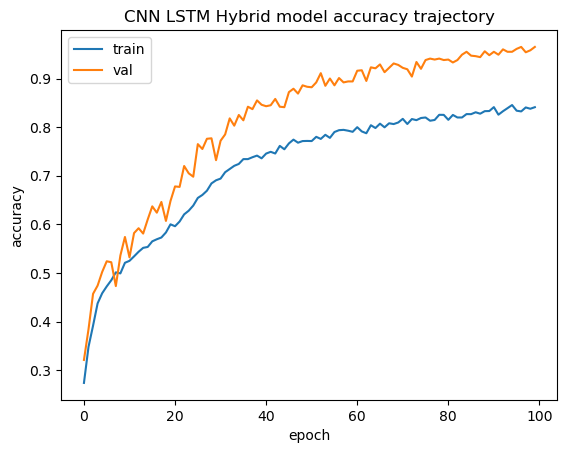

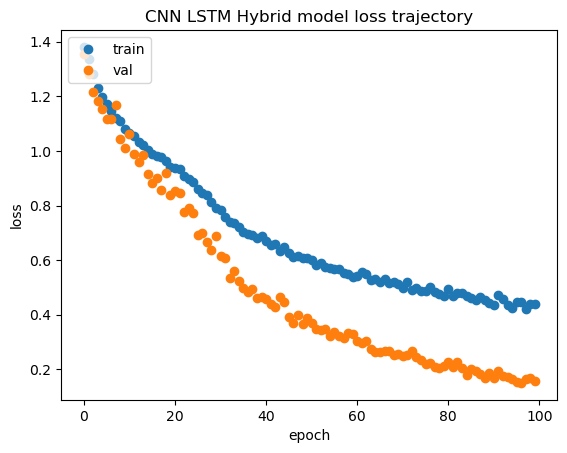

In [33]:
import matplotlib.pyplot as plt

# Plotting accuracy trajectory
plt.plot(hybrid_cnn_lstm_model_results.history['accuracy'])
plt.plot(hybrid_cnn_lstm_model_results.history['val_accuracy'])
plt.title('CNN LSTM Hybrid model accuracy trajectory')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plotting loss trajectory
plt.plot(hybrid_cnn_lstm_model_results.history['loss'],'o')
plt.plot(hybrid_cnn_lstm_model_results.history['val_loss'],'o')
plt.title('CNN LSTM Hybrid model loss trajectory')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [34]:
## Testing the basic RNN model

rnn_score = hybrid_cnn_lstm_model.evaluate(x_test, y_test, verbose=0)
print('Test accuracy of the hybrid CNN LSTM model:',rnn_score[1])

Test accuracy of the hybrid CNN LSTM model: 0.7133182883262634
